# Tuning the trust updater functionality

In [1]:
%load_ext autoreload
%autoreload 2
    
from typing import List
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt
from avtrust import TrustBetaDistribution, TrustArray, Psm, PsmArray

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def init_agent_trusts(
    alpha0: float = 1.0,
    beta0: float = 1.0,
    negativity_bias: float = 1.0,
    n_agents: int = 4,
):
    """Initialize vanilla trust distributions"""
    trusts = TrustArray(
        timestamp=0.0,
        trusts=[
            TrustBetaDistribution(
                timestamp=0.0,
                identifier=i_agent,
                alpha=alpha0,
                beta=beta0,
                negativity_bias=negativity_bias,
            )
            for i_agent in range(n_agents)
        ]
    )
    return trusts

def randn_clipped(
    rng: np.random.RandomState,
    v_mean: float=0.0,
    v_sigma: float=1.0,
    v_min: float=-np.inf,
    v_max: float=np.inf,
):
    return min(v_max, max(v_min, v_mean + v_sigma * rng.randn()))

def get_psms_for_target(
    timestamp: float,
    target: int,
    sources: List[int],
    value_mean: List[float],
    value_sigma: List[float],
    confidence_mean: List[float],
    confidence_sigma: List[float],
    rng: np.random.RandomState,
):
    """Get an array of random psms"""
    zip_loops = zip(
        sources,
        value_mean,
        value_sigma,
        confidence_mean,
        confidence_sigma
    )
    psms = PsmArray(
        timestamp=timestamp,
        psms=[
            Psm(
                timestamp=timestamp,
                target=target,
                value=randn_clipped(rng, vm, vs, 0.0, 1.0),
                confidence=randn_clipped(rng, cm, vs, 0.0, 1.0),
                source=source
            )
            for source, vm, vs, cm, vs in zip_loops
       ]
    )
    return psms


def get_psms(
    rng: np.random.RandomState,
    timestamp: float,
    i_agent: int,
    n_msmts: int,
    vm: float,
    vs: float,
    cm: float,
    cs: float,
):
    """Wrapper for getting a list of psms"""
    sources = list(range(n_msmts))
    value_mean = [vm] * n_msmts
    value_sigma = [vs] * n_msmts
    conf_mean = [cm] * n_msmts
    conf_sigma = [cs] * n_msmts
    psms = get_psms_for_target(
        rng=rng,
        timestamp=timestamp,
        target=i_agent,
        sources=sources,
        value_mean=value_mean,
        value_sigma=value_sigma,
        confidence_mean=conf_mean,
        confidence_sigma=conf_sigma,
    )
    return psms

### Scenario 1: Positive trust values should ultimately converge

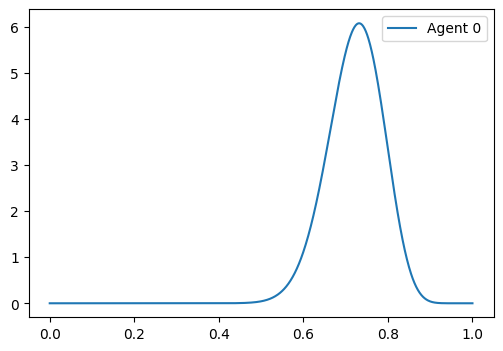

In [11]:
# random seed
seed = 1
rng = np.random.RandomState(seed=seed)

# scenario parameters
n_frames = 20
dt = 0.1
n_agents = 1
n_msmts = 5

# run trust loop
trusts = init_agent_trusts(n_agents=n_agents, negativity_bias=10.0)
for i_frame in range(n_frames):
    for i_agent in range(n_agents):
        # positive psms
        psms = get_psms(
            rng=rng,
            i_agent=i_agent,
            timestamp=dt*i_frame,
            n_msmts=n_msmts,
            vm=0.8,
            vs=0.2,
            cm=0.8,
            cs=0.2
        )
        # update
        for psm in psms:
            trusts[i_agent].update(psm)

# plot results
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
x_trust = np.linspace(0.0, 1.0, num=1000)
for i_agent in range(n_agents):
    y_trust = beta.pdf(x_trust, trusts[i_agent].alpha, trusts[i_agent].beta)
    ax.plot(x_trust, y_trust, label=f"Agent {i_agent}")
plt.legend()
plt.show()

### Scenario 2: Negative trust values should outweigh the positives

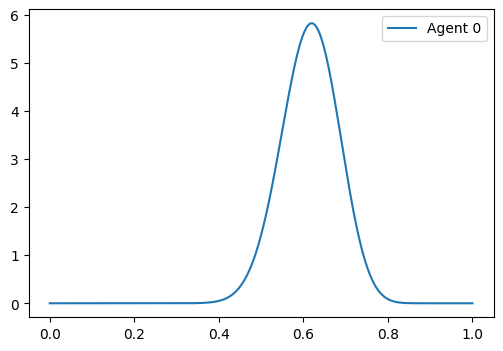

In [31]:
# random seed
seed = 1
rng = np.random.RandomState(seed=seed)

# scenario parameters
n_frames = 20
dt = 0.1
n_agents = 1
n_msmts_positive = 4
n_msmts_negative = 1

# run trust loop
trusts = init_agent_trusts(n_agents=n_agents, negativity_bias=2.0)
for i_frame in range(n_frames):
    for i_agent in range(n_agents):
        # positive psms
        psms_positive = get_psms(
            rng=rng,
            i_agent=i_agent,
            timestamp=dt*i_frame,
            n_msmts=n_msmts_positive,
            vm=0.9,
            vs=0.2,
            cm=0.8,
            cs=0.2
        )
        # negative psms
        psms_negative = get_psms(
            rng=rng,
            i_agent=i_agent,
            timestamp=dt*i_frame,
            n_msmts=n_msmts_negative,
            vm=0.2,
            vs=0.2,
            cm=0.8,
            cs=0.2
        )
        # update
        for psm in [*psms_positive, *psms_negative]:
            trusts[i_agent].update(psm)

# plot results
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
x_trust = np.linspace(0.0, 1.0, num=1000)
for i_agent in range(n_agents):
    y_trust = beta.pdf(x_trust, trusts[i_agent].alpha, trusts[i_agent].beta)
    ax.plot(x_trust, y_trust, label=f"Agent {i_agent}")
plt.legend()
plt.show()